In [301]:
!pip install kagglehub

In [302]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("yingwurenjian/chicago-divvy-bicycle-sharing-data")

print("Path to dataset files:", path)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/yingwurenjian/chicago-divvy-bicycle-sharing-data/versions/1


In [303]:
import pandas as pd
df = pd.read_csv(path+"/data.csv", nrows=1_000_000)

In [304]:
from sklearn.model_selection import train_test_split

df, df_final_holdout = train_test_split(df, test_size=0.5, random_state=42)

In [305]:
df_final_holdout = df_final_holdout.reset_index()

In [306]:
df = df.reset_index()
x = df.drop(columns = ['tripduration'])
y = df['tripduration']

In [307]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=1/3, random_state=42
)


In [308]:
x_train = x_train.reset_index()
# this the data that will be used to train the data 


In [309]:
x_train

,level_0,index,trip_id,year,month,week,day,hour,usertype,gender,...,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,135822,351158,1571305,2014,5,19,0,6,Subscriber,Male,...,236,Sedgwick St & Schiller St,41.907576,-87.638517,15.0,98,LaSalle St & Washington St,41.882664,-87.632530,15.0
1,493709,658250,2718802,2014,7,30,1,12,Subscriber,Female,...,49,Dearborn St & Monroe St,41.881320,-87.629521,23.0,164,Franklin St & Lake St,41.885837,-87.635500,23.0
2,456256,117949,2093127,2014,6,24,5,9,Subscriber,Female,...,118,Sedgwick St & North Ave,41.910579,-87.638618,19.0,313,Lakeview Ave & Fullerton Pkwy,41.925858,-87.638973,19.0
3,337375,690107,2642882,2014,7,29,4,13,Subscriber,Male,...,37,Dearborn St & Adams St,41.879356,-87.629791,19.0,106,State St & Pearson St,41.897448,-87.628722,27.0
4,275839,2005,2351636,2014,6,27,0,16,Subscriber,Male,...,191,Canal St & Monroe St,41.880700,-87.639470,23.0,195,Columbus Dr & Randolph St,41.884728,-87.619521,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333328,259178,303271,1672549,2014,5,20,2,12,Subscriber,Male,...,33,State St & Van Buren St,41.877181,-87.627844,27.0,273,Michigan Ave & 18th St,41.857937,-87.623633,15.0
333329,365838,280691,1724661,2014,5,21,0,19,Subscriber,Female,...,56,Desplaines St & Kinzie St,41.888716,-87.644448,19.0,66,Clinton St & Lake St,41.885833,-87.641382,19.0
333330,131932,449096,1362707,2014,4,15,1,18,Subscriber,Male,...,111,Sedgwick St & Huron St,41.894666,-87.638437,19.0,91,Clinton St & Washington Blvd,41.883380,-87.641170,31.0
333331,146867,373557,1525616,2014,4,18,1,8,Subscriber,Male,...,186,Ogden Ave & Race Ave,41.891795,-87.658751,15.0,196,Cityfront Plaza & N Water St,41.889875,-87.621994,19.0


In [310]:
x_test = x_test.reset_index()

In [311]:
x_test

,level_0,index,trip_id,year,month,week,day,hour,usertype,gender,...,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,104241,559445,1143725,2014,1,4,3,16,Subscriber,Male,...,150,Fort Dearborn Dr & 31st St,41.838556,-87.608218,11.0,272,Indiana Ave & 31st St,41.838842,-87.621857,11.0
1,199676,144549,2042287,2014,6,24,1,6,Subscriber,Male,...,226,Racine Ave & Belmont Ave,41.939743,-87.658865,15.0,58,Marshfield Ave & Cortland St,41.916017,-87.668879,19.0
2,140199,548679,1166375,2014,2,6,4,1,Subscriber,Male,...,327,Sheffield Ave & Webster Ave,41.921687,-87.653714,19.0,13,Wilton Ave & Diversey Pkwy,41.932500,-87.652681,19.0
3,132814,922814,3617367,2014,9,38,2,8,Subscriber,Male,...,251,Clarendon Ave & Leland Ave,41.967968,-87.650001,15.0,314,Ravenswood Ave & Berteau Ave,41.957921,-87.673567,15.0
4,408697,396993,1479980,2014,4,17,1,20,Subscriber,Male,...,325,Clark St & Winnemac Ave,41.973385,-87.668365,15.0,326,Clark St & Leland Ave,41.967096,-87.667429,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166662,69633,340939,1590013,2014,5,19,2,8,Subscriber,Male,...,56,Desplaines St & Kinzie St,41.888716,-87.644448,19.0,217,May St & Fulton St,41.886773,-87.656001,15.0
166663,489162,798623,2398685,2014,7,27,3,17,Subscriber,Male,...,67,Sheffield Ave & Fullerton Ave,41.925602,-87.653708,15.0,300,Broadway & Barry Ave,41.937725,-87.644095,15.0
166664,452894,876643,3705598,2014,9,39,1,17,Subscriber,Female,...,53,Wells St & Erie St,41.893832,-87.634195,19.0,289,Wells St & Concord Ln,41.912202,-87.634664,19.0
166665,439140,571705,1120540,2014,1,3,0,13,Subscriber,Male,...,283,LaSalle St & Jackson Blvd,41.878170,-87.631985,23.0,77,Clinton St & Madison St,41.881582,-87.641277,23.0


## 1.2 Feature Engineering 

To start off our feature engineering we are going to drop the columns trip_id, starttime, and stoptime from the list of predictors. We will drop starttime because the same information is captured in year, month, week, day and hour columns. We will drop stoptime variable to ensure that our model is not simply just using starttime (year/month/week/day/hour) and stoptime to calculate tripduration. We will drop trip_id because it is a unique identifier for database not a true predictor. 

In [312]:
x_train = x_train.drop(columns = ['trip_id','starttime','stoptime'])
t_test = x_test.drop(columns =['trip_id','starttime','stoptime'])

In [313]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333333 entries, 0 to 333332
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   level_0            333333 non-null  int64  
 1   index              333333 non-null  int64  
 2   year               333333 non-null  int64  
 3   month              333333 non-null  int64  
 4   week               333333 non-null  int64  
 5   day                333333 non-null  int64  
 6   hour               333333 non-null  int64  
 7   usertype           333333 non-null  object 
 8   gender             333333 non-null  object 
 9   temperature        333333 non-null  float64
 10  events             333333 non-null  object 
 11  from_station_id    333333 non-null  int64  
 12  from_station_name  333333 non-null  object 
 13  latitude_start     333333 non-null  float64
 14  longitude_start    333333 non-null  float64
 15  dpcapacity_start   333333 non-null  float64
 16  to

Addressing the station_name and station_id. There are about 300+ unique station_id and station_name. While trying to fit a linear regression model with these as categories the model did very poorly. Once, the frequency data was extracted the model did much better and we dropped the station_id and station_name. 

In [314]:
# creates a measure for how busy a given station is 
# the following would be our temporal features, since frequency is a measure of relative traffic across time 

from_station_freq = x_train['from_station_id'].value_counts() 
x_train['from_station_id_freq'] = x_train['from_station_id'].map(from_station_freq)

to_station_freq = x_train['to_station_id'].value_counts()
x_train['to_station_id_freq'] = x_train['to_station_id'].map(to_station_freq)

from_station_freq_test = x_test['from_station_id'].value_counts() 
x_test['from_station_id_freq'] = x_test['from_station_id'].map(to_station_freq)

to_station_freq = x_train['to_station_id'].value_counts()
x_test['to_station_id_freq'] = x_test['to_station_id'].map(to_station_freq)

# dropping station information because we have already extracted all useful information in from of frequency metric 
x_train = x_train.drop(columns = ['from_station_id','to_station_id','from_station_name','to_station_name'])
x_test = x_test.drop(columns = ['from_station_id','to_station_id','from_station_name','to_station_name'])

In [315]:
# converts start lattitude and longitude to Manhattan distance  
# a function that outputs the manhattan distance for two points 
# the following would be our spatial features 
import numpy as np 
def manhattan_distance(lat1, lon1, lat2, lon2):
    # Convert degree differences
    dlat = np.abs(lat1 - lat2)
    dlon = np.abs(lon1 - lon2)
    
    # Convert to kilometers
    lat_km = dlat * 111
    lon_km = dlon * 111 * np.cos(np.radians((lat1 + lat2) / 2))
    
    return lat_km + lon_km

x_train['manhattan_km'] = manhattan_distance(
    x_train['latitude_start'],
    x_train['longitude_start'],
    x_train['latitude_end'],
    x_train['longitude_end'])

x_test['manhattan_km'] = manhattan_distance(
    x_test['latitude_start'],
    x_test['longitude_start'],
    x_test['latitude_end'],
    x_test['longitude_end'])


# dropping data to reduce redundancy
x_train = x_train.drop(columns = ['latitude_start',
                                 'longitude_start',
                                 'latitude_end',
                                 'longitude_end'])


x_test = x_test.drop(columns = ['latitude_start',
                                 'longitude_start',
                                 'latitude_start',
                                 'longitude_end'])

In [316]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# day, week, month, year and hour are int64 and should be treated as categorical data 
cols = ['year','month','week','day','hour']
x_train[cols] = x_train[cols].astype('category')
x_test[cols] = x_test[cols].astype('category')

In [317]:
# here we are determining the catergoircal predictors in our data 
categorical_cols = x_train.select_dtypes(include=['object', 'category']).columns
numeric_cols = x_train.select_dtypes(include=['number']).columns

categorical_cols_test = x_test.select_dtypes(include=['object', 'category']).columns
numeric_cols_test = x_test.select_dtypes(include=['number']).columns

# encodes categorical data 
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

In [318]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333333 entries, 0 to 333332
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   level_0               333333 non-null  int64   
 1   index                 333333 non-null  int64   
 2   year                  333333 non-null  category
 3   month                 333333 non-null  category
 4   week                  333333 non-null  category
 5   day                   333333 non-null  category
 6   hour                  333333 non-null  category
 7   usertype              333333 non-null  object  
 8   gender                333333 non-null  object  
 9   temperature           333333 non-null  float64 
 10  events                333333 non-null  object  
 11  dpcapacity_start      333333 non-null  float64 
 12  dpcapacity_end        333333 non-null  float64 
 13  from_station_id_freq  333333 non-null  int64   
 14  to_station_id_freq    333333 non-nul

## 1.3 Fitting Linear Model

In [319]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

model_Linear = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())])

model_Linear.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['year', 'month', 'week', 'day', 'hour', 'usertype', 'gender', 'events'], dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['level_0', 'index', 'temperature', 'dpcapacity_start', 'dpcapacity_end',
       'from_station_id_freq', 'to_station_id_freq', 'manhattan_km'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [321]:
print("Base Mode Linear Regression R^2:", model_Linear.score(x_train, y_train))

Base Mode Linear Regression R^2: 0.6211505364251526


In [322]:
from sklearn.metrics import mean_squared_error
# the prediction of tripduration according to the fitted linear model
y_pred = model_Linear.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("Base Linear Regression test MSE:", mse)

rmse = mean_squared_error(y_test, y_pred, squared = False)
print("Base Linear Regression test RMSE:", rmse)

Base Linear Regression test MSE: 19.79497779281493
Base Linear Regression test RMSE: 4.449154727902249


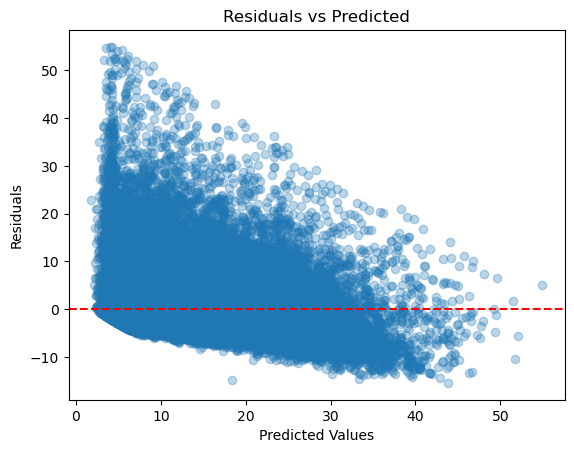

In [323]:
residuals = y_test - y_pred

import matplotlib.pyplot as plt

plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


Residuals very highly dispersed initially. They do not appear to be distributed about 0 before predicted value of 25. Once the predicted value climbs to past 25 it seems that the residuals are distributed about 0. This implies that linear regression model assumtion that error is distributed around zero is violated. 

Implementation of ridge regression with cross validation 
Here Ridge regression is just the implementation of linear regression with the L2-Regularization term (i.e. loss function is as follows):
$$Loss(\beta_1,...,\beta_p,\alpha) = \sum_{i=1}^{n}(y_i-\hat{y_i})^2 + \alpha\sum_{j=1}^{p}\beta_{j}^{2}$$
Here the first term measures the error, the second term penalizes the square of the coefficient values and $\alpha$ determines how strongly coefficients are constrained. In the following implementation we use cross validation to tune the hyper-parameter $\alpha$.

In [324]:
from sklearn.linear_model import RidgeCV
alphas = np.logspace(-3, 3, 50)


ridge_cv_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', RidgeCV(alphas=alphas, cv=5))
])

ridge_cv_pipeline.fit(x_train, y_train)


print("R^2 value is:", ridge_cv_pipeline.score(x_train, y_train))
print("Best alpha:", ridge_cv_pipeline.named_steps['regressor'].alpha_)

R^2 value is: 0.6114396196538585
Best alpha: 0.0017575106248547913


In [325]:
y_predRidge = ridge_cv_pipeline.predict(x_test)
mse_Ridge = mean_squared_error(y_test, y_predRidge)
print("Ridge Regression test MSE:", mse_Ridge)

rmse_Ridge = mean_squared_error(y_test, y_predRidge, squared = False)
print("Ridge Regression test RMSE:", rmse_Ridge)

Ridge Regression test MSE: 20.332990234284825
Ridge Regression test RMSE: 4.509211708745202


Implementation of Lasso Regression with cross validation. Here Lasso Regression is just the implementation of linear regression with the L1-Regularization.
$$Loss(\beta_1,...,\beta_n, \alpha) =\sum_{i=1}^{n}(y_{i}-\hat{y_{i}})^2 +\alpha \sum_{j=1}^{p}|\beta_{j}|$$
Here the first term measures the prediction error, the second term penalizes absolute coefficient values and $\alpha$ determines how strongly coefficients are constrained. In the following implementation we use cross validation to tune the hyper-parameter $\alpha$.

In [326]:
from sklearn.linear_model import LassoCV

alphas_Lasso = np.logspace(-4, 1, 50)


lasso_cv_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', LassoCV(alphas=None, cv=5, max_iter = 10000,
                         n_jobs = -1, random_state = 42))
])

lasso_cv_pipeline.fit(x_train, y_train)
print("R^2 value is:", lasso_cv_pipeline.score(x_train, y_train))

print("Best alpha:", lasso_cv_pipeline.named_steps['regressor'].alpha_)

R^2 value is: 0.00809953322007062
Best alpha: 39.57150613676321


In [327]:
y_predLasso = lasso_cv_pipeline.predict(x_test)
mse_Lasso = mean_squared_error(y_test, y_predLasso)
print("Lasso Regression test MSE:", mse_Lasso)

rmse_Lasso = mean_squared_error(y_test, y_predLasso, squared = False)
print("Lasso Regression test RMSE:", rmse_Lasso)

Lasso Regression test MSE: 51.76119898432274
Lasso Regression test RMSE: 7.194525626080064
